In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/text-augmentation/review_aug_insert.csv
/kaggle/input/shopee-sentiment-analysis/test.csv
/kaggle/input/shopee-sentiment-analysis/train.csv
/kaggle/input/shopee-sentiment-analysis/sampleSubmission.csv


# Loading the data

In [2]:
train =  pd.read_csv('../input/shopee-sentiment-analysis/train.csv')
test = pd.read_csv('../input/shopee-sentiment-analysis/test.csv')

# printing first five rows of the files
print('First five rows of training data:\n',train.head(),'\n')
print('First five rows of testing data:\n',test.head())

First five rows of training data:
    review_id                                             review  rating
0          0  Ga disappointed neat products .. Meletot Hilsn...       1
1          1    Rdtanya replace broken glass, broken chargernya       1
2          2  Nyesel bngt dsni shopping antecedent photo mes...       1
3          3      Sent a light blue suit goods ga want a refund       1
4          4  Pendants came with dents and scratches on its ...       1 

First five rows of testing data:
    review_id                                             review
0          1  Great danger, cool, motif and cantik2 jg model...
1          2                   One of the shades don't fit well
2          3                                   Very comfortable
3          4  Fast delivery. Product expiry is on Dec 2022. ...
4          5  it's sooooo cute! i like playing with the glit...


# Data Exploration
We see that there are no missing values in the training data set.

In [3]:
# check data info
train.info()
print('\n')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146811 entries, 0 to 146810
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   review_id  146811 non-null  int64 
 1   review     146811 non-null  object
 2   rating     146811 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60427 entries, 0 to 60426
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review_id  60427 non-null  int64 
 1   review     60427 non-null  object
dtypes: int64(1), object(1)
memory usage: 944.3+ KB


In [4]:
# drop unwanted column from train data

train.drop('review_id', axis=1, inplace=True)
print('Train shape:', train.shape)

Train shape: (146811, 2)


# Imbalanced Classes
We see that there are generally more postive ratings (>= 3) per review.

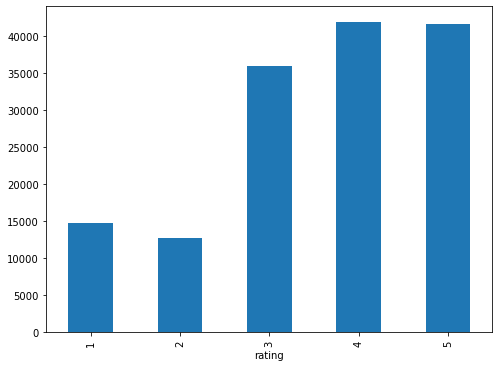

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
train.groupby('rating').review.count().plot.bar(ylim=0)
plt.show()

# Clean Emoji

In [6]:
import emoji 

have_emoji_train_idx = []
have_emoji_test_idx = []

for idx, review in enumerate(train['review']):
    if any(char in emoji.UNICODE_EMOJI for char in review):
        have_emoji_train_idx.append(idx)
        
for idx, review in enumerate(test['review']):
    if any(char in emoji.UNICODE_EMOJI for char in review):
        have_emoji_test_idx.append(idx)

def emoji_cleaning(text):
    
    # Change emoji to text
    text = emoji.demojize(text).replace(":", " ")
    
    # Delete repeated emoji
    tokenizer = text.split()
    repeated_list = []
    
    for word in tokenizer:
        if word not in repeated_list:
            repeated_list.append(word)
    
    text = ' '.join(text for text in repeated_list)
    text = text.replace("_", " ").replace("-", " ")
    return text

# emoji_cleaning
train.loc[have_emoji_train_idx, 'review'] = train.loc[have_emoji_train_idx, 'review'].apply(emoji_cleaning)
test.loc[have_emoji_test_idx, 'review'] = test.loc[have_emoji_test_idx, 'review'].apply(emoji_cleaning)


# after cleaning
train.loc[have_emoji_train_idx, 'review'].tail()

146782    Mantul ... smiling face with heart eyes thumbs...
146787    Her material is different different, but good ...
146800    Hehe thanks Baguuuuuuuuuuuus kaaaa smiling fac...
146801    Explore huge crowd here Children seem to like ...
146808    Awesome awesome quality merchandise value CP V...
Name: review, dtype: object

# Change Emoticon to Text

In [7]:
import re

def clean_emoticon(text):
    
    # change emoticon to text
    text = re.sub(r':\(', 'dislike', text)
    text = re.sub(r': \(\(', 'dislike', text)
    text = re.sub(r':, \(', 'dislike', text)
    text = re.sub(r':\)', 'smile', text)
    text = re.sub(r';\)', 'smile', text)
    text = re.sub(r':\)\)\)', 'smile', text)
    text = re.sub(r':\)\)\)\)\)\)', 'smile', text)
    text = re.sub(r'=\)\)\)\)', 'smile', text)
    
    return text

train['review'] = train['review'].apply(clean_emoticon)
test['review'] = test['review'].apply(clean_emoticon)

# Delete Repeated Words
Attempt to preprocess more than 2 repeated character.

In [8]:
repeated_rows_train = []
repeated_rows_test = []

for idx, review in enumerate(train['review']):
    if re.match(r'\w*(\w)\1+', review):
        repeated_rows_train.append(idx)
        
for idx, review in enumerate(test['review']):
    if re.match(r'\w*(\w)\1+', review):
        repeated_rows_test.append(idx)

def delete_repeated_char(text):
    
    text = re.sub(r'(\w)\1{2,}', r'\1', text)
    
    return text

train.loc[repeated_rows_train, 'review'] = train.loc[repeated_rows_train, 'review'].apply(delete_repeated_char)
test.loc[repeated_rows_test, 'review'] = test.loc[repeated_rows_test, 'review'].apply(delete_repeated_char)

# Delete Rows with Noisy Text or Incorrect Ratings
This was an attempt to find rows with noisy text/incorrect ratings

In [9]:
# drop the row that has noisy text or mislabeled rating
noisy_row = [31, 50, 160, 206, 353, 1128, 2235, 2545, 3682, 5244, 10409, 11748, 12308, 12384, 14395, 15215, 17629, 17935, 20819, 20820, 22628, 23691, 32089, 39532, 40530, 43954, 48186, 50500, 55834, 60088,
             60442, 61095, 62982, 63803, 67464, 70791, 74861, 73636, 74119, 76275, 79789, 85745, 91058, 91663, 91800, 93204, 99295, 100903, 101177, 103155,
             109166, 109566, 109651, 109724, 110115, 110441, 111461, 113175, 115782, 116903, 118099, 118328, 118414, 119071, 125338, 125340, 129496, 129640, 
             132027, 138212, 131626, 134715, 133248, 136217, 141377, 143707, 145045, 146485, 37301]

train.drop(noisy_row, inplace=True)

# Convert Slangs to its Original Word

In [10]:
def recover_shortened_words(text):
    
    # put \b (boundary) to avoid the characters in the word to be replaced
    
    text = re.sub(r'\bapaa\b', 'apa', text)
    text = re.sub(r'\bad\b', 'advertisement', text)
    
    text = re.sub(r'\bbsk\b', 'besok', text)
    text = re.sub(r'\bbrngnya\b', 'barangnya', text)
    text = re.sub(r'\bbrp\b', 'berapa', text)
    text = re.sub(r'\bbgt\b', 'banget', text)
    text = re.sub(r'\bbngt\b', 'banget', text)
    text = re.sub(r'\bgini\b', 'begini', text)
    text = re.sub(r'\bbrg\b', 'barang', text)
    
    text = re.sub(r'\bcpat\b', 'cepat', text)
    
    text = re.sub(r'\bdtg\b', 'datang', text)
    text = re.sub(r'\bd\b', 'di', text)
    text = re.sub(r'\bsdh\b', 'sudah', text)
    text = re.sub(r'\bdri\b', 'dari', text)
    text = re.sub(r'\bdsni\b', 'disini', text)
    text = re.sub(r'\btsk\b', 'disapprove', text)
    
    text = re.sub(r'\bgk\b', 'gak', text)
    
    text = re.sub(r'\bhrs\b', 'harus', text)
    
    text = re.sub(r'\bjd\b', 'jadi', text)
    text = re.sub(r'\bjg\b', 'juga', text)
    text = re.sub(r'\bjgn\b', 'jangan', text)
    
    text = re.sub(r'\blg\b', 'lagi', text)
    text = re.sub(r'\blgi\b', 'lagi', text)
    text = re.sub(r'\blbh\b', 'lebih', text)
    text = re.sub(r'\blbih\b', 'lebih', text)
    
    text = re.sub(r'\bmksh\b', 'makasih', text)
    text = re.sub(r'\bmna\b', 'mana', text)
    
    text = re.sub(r'\borg\b', 'orang', text)
    
    text = re.sub(r'\bpjg\b', 'panjang', text)
    
    text = re.sub(r'\bka\b', 'kakak', text)
    text = re.sub(r'\bkk\b', 'kakak', text)
    text = re.sub(r'\bklo\b', 'kalau', text)
    text = re.sub(r'\bkmrn\b', 'kemarin', text)
    text = re.sub(r'\bkmrin\b', 'kemarin', text)
    text = re.sub(r'\bknp\b', 'kenapa', text)
    text = re.sub(r'\bkcil\b', 'kecil', text)
    
    text = re.sub(r'\bgmn\b', 'gimana', text)
    text = re.sub(r'\bgmna\b', 'gimana', text)
    
    text = re.sub(r'\btp\b', 'tapi', text)
    text = re.sub(r'\btq\b', 'thanks', text)
    text = re.sub(r'\btks\b', 'thanks', text)
    text = re.sub(r'\btlg\b', 'tolong', text)
    text = re.sub(r'\bgk\b', 'tidak', text)
    text = re.sub(r'\bgak\b', 'tidak', text)
    text = re.sub(r'\bgpp\b', 'tidak apa apa', text)
    text = re.sub(r'\bgapapa\b', 'tidak apa apa', text)
    text = re.sub(r'\bga\b', 'tidak', text)
    text = re.sub(r'\btgl\b', 'tanggal', text)
    text = re.sub(r'\btggl\b', 'tanggal', text)
    text = re.sub(r'\bgamau\b', 'tidak mau', text)
    
    text = re.sub(r'\bsy\b', 'saya', text)
    text = re.sub(r'\bsis\b', 'sister', text)
    text = re.sub(r'\bsdgkan\b', 'sedangkan', text)
    text = re.sub(r'\bmdh2n\b', 'semoga', text)
    text = re.sub(r'\bsmoga\b', 'semoga', text)
    text = re.sub(r'\bsmpai\b', 'sampai', text)
    text = re.sub(r'\bnympe\b', 'sampai', text)
    text = re.sub(r'\bdah\b', 'sudah', text)
    
    text = re.sub(r'\bpls\b', 'please', text)
    text = re.sub(r'\bpcs\b', 'pieces', text)
    text = re.sub(r'\bfoto\b', 'photo', text)
    text = re.sub(r'\bpic\b', 'picture', text)
    text = re.sub(r'\bpict\b', 'picture', text)
    
    text = re.sub(r'\bberkali2\b', 'repeated', text)
    
    text = re.sub(r'\byg\b', 'yang', text)
    
    return text

train['review'] = train['review'].apply(recover_shortened_words)
test['review'] = test['review'].apply(recover_shortened_words)

# Text Cleaning for Modelling

1. Remove punctuation
2. Delete new line
3. Tokenization + Converting to lowercase + Strip Whitespaces
4. Remove Stopwords
5. Lemmatization

In [11]:
import string

# Remove punctuation

def remove_punctuation(text):
    no_punct = "".join([word for word in text if word not in string.punctuation])
    return no_punct


train['review'] = train['review'].apply(lambda x: remove_punctuation(x))

train['review'].head()

0    Ga disappointed neat products  Meletot Hilsnya...
1       Rdtanya replace broken glass broken chargernya
2    Nyesel banget disini shopping antecedent photo...
3     Sent a light blue suit goods tidak want a refund
4    Pendants came with dents and scratches on its ...
Name: review, dtype: object

In [12]:
# Remove new line

def remove_newline(text):
    del_line = "".join([word for word in text.split('\n') if word.strip() != ''])
    return del_line

train['review'] = train['review'].apply(lambda x: remove_newline(x))

train['review'].head()

0    Ga disappointed neat products  Meletot Hilsnya...
1       Rdtanya replace broken glass broken chargernya
2    Nyesel banget disini shopping antecedent photo...
3     Sent a light blue suit goods tidak want a refund
4    Pendants came with dents and scratches on its ...
Name: review, dtype: object

In [13]:
from nltk.tokenize import RegexpTokenizer

# Tokenize, convert to lowercase, and strip whitespaces

tokenizer = RegexpTokenizer(r'\w+')

train['review'] = train['review'].apply(lambda x: tokenizer.tokenize(x.lower().strip()))

train['review'].head()

0    [ga, disappointed, neat, products, meletot, hi...
1    [rdtanya, replace, broken, glass, broken, char...
2    [nyesel, banget, disini, shopping, antecedent,...
3    [sent, a, light, blue, suit, goods, tidak, wan...
4    [pendants, came, with, dents, and, scratches, ...
Name: review, dtype: object

In [14]:
from nltk.corpus import stopwords

# remove stop words

def remove_stopwords(text):
    words = " ".join([word for word in text if word not in stopwords.words('english')])
    return words

train['review'] = train['review'].apply(lambda x: remove_stopwords(x))

train['review'].head()

0    ga disappointed neat products meletot hilsnyaa...
1       rdtanya replace broken glass broken chargernya
2    nyesel banget disini shopping antecedent photo...
3         sent light blue suit goods tidak want refund
4    pendants came dents scratches surface coating ...
Name: review, dtype: object

In [15]:
import spacy

# Lemmatizing
# Initialize spacy 'en' model, keeping only tagger component needed for lemmatization
nlp = spacy.load('en', disable=['parser', 'ner'])

def word_lemmatizer(text):
    lem_text = " ".join([word.lemma_ for word in nlp(text)])
    return lem_text

train['review'] = train['review'].apply(lambda x: word_lemmatizer(x))

train['review'].head()

0    ga disappoint neat product meletot hilsnyaa sp...
1         rdtanya replace break glass break chargernya
2    nyesel banget disini shopping antecedent photo...
3          send light blue suit good tidak want refund
4    pendant come dent scratch surface coating look...
Name: review, dtype: object

# Exploring Text Augmentation (TBD)
Using text augmentation, we can try to generate more rating 1 & 2 training dataset to tackle the problem of class imbalance. Here we'll attempt to use Contextualized Word Embeddings.

Since the codes below took hours to run, we'll just be using the data generated from running the codes below from another notebook.

In [16]:
#!pip install nlpaug -q

In [17]:
#import nlpaug.augmenter.char as nac
#import nlpaug.augmenter.word as naw

In [18]:
#%%time

#review_augmented = []

# action = "insert" or 'substitute (default)'
#aug = naw.ContextualWordEmbsAug(model_path='bert-base-multilingual-uncased', action='insert')

#aug = naw.ContextualWordEmbsAug(model_path='bert-base-multilingual-uncased', action='substitute', aug_p=0.5) # higher aug_p = substitute more words

#ratings = [1,2]
#train1_and_2 = train[train.rating.isin(ratings)]
#train1_and_2.shape

In [19]:
#for review in train1_and_2['review']:    
#    augmented_text = aug.augment(review)
#    review_augmented.append(augmented_text)
    
#train_aug = pd.DataFrame({'review': review_augmented,
#                          'rating': train1_and_2['rating']})


In [20]:
# export to csv
#train_aug.to_csv('review_aug_insert.csv', index=False)

In [21]:
#train_aug =  pd.read_csv('/kaggle/input/text-augmentation/review_aug_insert.csv')

#print('train aug shape:', train_aug.shape)

In [22]:
# filter away null values
#train_aug = train_aug[train_aug.review.notnull()]

#print('train aug shape:', train_aug.shape)

In [23]:
# clean the augmented text
#train_aug['review'] = train_aug['review'].apply(lambda x: remove_punctuation(x))
#train_aug['review'] = train_aug['review'].apply(lambda x: remove_newline(x))
#train_aug['review'] = train_aug['review'].apply(lambda x: tokenizer.tokenize(x.lower().strip()))
#train_aug['review'] = train_aug['review'].apply(lambda x: remove_stopwords(x))
#train_aug['review'] = train_aug['review'].apply(lambda x: word_lemmatizer(x))

In [24]:
#from nltk import word_tokenize#

# Tokenize each item in the review column
#word_tokens = [word_tokenize(review) for review in train_aug.review]

# Create an empty list to store the length of the reviews
#len_tokens = []

# Iterate over the word_tokens list and determine the length of each item
#for i in range(len(word_tokens)):
#     len_tokens.append(len(word_tokens[i]))

# Create a new feature for the lengh of each review
#train_aug['n_words'] = len_tokens 

In [25]:
# filter away rows that have less than 3 words

#train_aug = train_aug[train_aug['n_words'] >= 3]
#print('train aug shape:', train_aug.shape)

In [26]:
#train_aug.drop('n_words', axis=1, inplace=True)

In [27]:
#train = pd.concat([train, train_aug], axis=0, ignore_index=True)

In [28]:
#import matplotlib.pyplot as plt
#fig = plt.figure(figsize=(8,6))
#train.groupby('rating').review.count().plot.bar(ylim=0)
#plt.show()

# Prepare Test Set for Prediction

In [29]:
# drop unwanted column from test data
test_dup = test[['review_id', 'review']]
test.drop('review_id', axis=1, inplace=True)
print('Test shape:', test.shape)
print('Test Dup shape:', test_dup.shape)

Test shape: (60427, 1)
Test Dup shape: (60427, 2)


In [30]:
test['review'] = test['review'].apply(lambda x: remove_punctuation(x))
test['review'].head()

0    Great danger cool motif and cantik2 juga model...
1                      One of the shades dont fit well
2                                     Very comfortable
3    Fast delivery Product expiry is on Dec 2022 Pr...
4    its sooooo cute i like playing with the glitte...
Name: review, dtype: object

In [31]:
test['review'] = test['review'].apply(lambda x: remove_newline(x))
test['review'].head()

0    Great danger cool motif and cantik2 juga model...
1                      One of the shades dont fit well
2                                     Very comfortable
3    Fast delivery Product expiry is on Dec 2022 Pr...
4    its sooooo cute i like playing with the glitte...
Name: review, dtype: object

In [32]:
test['review'] = test['review'].apply(lambda x: tokenizer.tokenize(x.lower()))
test['review'].head()

0    [great, danger, cool, motif, and, cantik2, jug...
1              [one, of, the, shades, dont, fit, well]
2                                  [very, comfortable]
3    [fast, delivery, product, expiry, is, on, dec,...
4    [its, sooooo, cute, i, like, playing, with, th...
Name: review, dtype: object

In [33]:
test['review'] = test['review'].apply(lambda x: remove_stopwords(x))
test['review'].head()

0    great danger cool motif cantik2 juga models de...
1                             one shades dont fit well
2                                          comfortable
3    fast delivery product expiry dec 2022 product ...
4    sooooo cute like playing glitters better brows...
Name: review, dtype: object

In [34]:
test['review'] = test['review'].apply(lambda x: word_lemmatizer(x))
test['review'].head()

0    great danger cool motif cantik2 juga model del...
1                            one shade do not fit well
2                                          comfortable
3    fast delivery product expiry dec 2022 product ...
4    sooooo cute like play glitter better browse ph...
Name: review, dtype: object

# Modeling (using TensorFlow)

In [35]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

import transformers
from transformers import TFAutoModel, AutoTokenizer
from tqdm.notebook import tqdm
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [36]:
def regular_encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
             texts, 
             return_attention_masks=False, 
             return_token_type_ids=False,
             pad_to_max_length=True,
             max_length=maxlen)
    
    return np.array(enc_di['input_ids'])

In [37]:
def build_model(transformer, max_len=512):
    
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(5, activation='softmax')(cls_token) # 5 ratings to predict
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [38]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [39]:
# For tf.dataset
AUTO = tf.data.experimental.AUTOTUNE

# Configuration
EPOCHS = 4
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
MODEL = 'jplu/tf-xlm-roberta-large' # bert-base-multilingual-uncased

In [40]:
# since tf.keras reads your data take 0 as the reference, our category should start from 0 not 1
rating_mapper_encode = {1: 0,
                        2: 1,
                        3: 2,
                        4: 3,
                        5: 4}

# convert back to original rating after prediction later
rating_mapper_decode = {0: 1,
                        1: 2,
                        2: 3,
                        3: 4,
                        4: 5}

train['rating'] = train['rating'].map(rating_mapper_encode)

In [41]:
from tensorflow.keras.utils import to_categorical

# convert to one-hot-encoding-labels
train_labels = to_categorical(train['rating'], num_classes=5)

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train['review'],
                                                  train_labels,
                                                  stratify=train_labels,
                                                  test_size=0.2,
                                                  random_state=456)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((117385,), (29347,), (117385, 5), (29347, 5))

In [43]:
# load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [44]:
MAX_LEN = 192

X_train = regular_encode(X_train.values, tokenizer, maxlen=MAX_LEN)
X_val = regular_encode(X_val.values, tokenizer, maxlen=MAX_LEN)
X_test = regular_encode(test['review'].values, tokenizer, maxlen=MAX_LEN)

In [45]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_train, y_train))
    .repeat()
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_val, y_val))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(X_test)
    .batch(BATCH_SIZE)
)

In [46]:
%%time

with strategy.scope():
    transformer_layer = TFAutoModel.from_pretrained(MODEL)
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 192)]             0         
_________________________________________________________________
tf_roberta_model (TFRobertaM ((None, 192, 1024), (None 559890432 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 1024)]            0         
_________________________________________________________________
dense (Dense)                (None, 5)                 5125      
Total params: 559,895,557
Trainable params: 559,895,557
Non-trainable params: 0
_________________________________________________________________
CPU times: user 2min 9s, sys: 38.5 s, total: 2min 47s
Wall time: 4min 41s


In [47]:
n_steps = X_train.shape[0] // BATCH_SIZE

train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS
)

Epoch 1/4


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)


917/917 [==============================] - 440s 480ms/step - loss: 1.5655 - accuracy: 0.2768 - val_loss: 1.5045 - val_accuracy: 0.2495
Epoch 2/4
917/917 [==============================] - 407s 444ms/step - loss: 1.4062 - accuracy: 0.3248 - val_loss: 1.2873 - val_accuracy: 0.3993
Epoch 3/4
917/917 [==============================] - 407s 444ms/step - loss: 1.2387 - accuracy: 0.4063 - val_loss: 1.2447 - val_accuracy: 0.4328
Epoch 4/4
917/917 [==============================] - 408s 445ms/step - loss: 1.1749 - accuracy: 0.4372 - val_loss: 1.1601 - val_accuracy: 0.4546


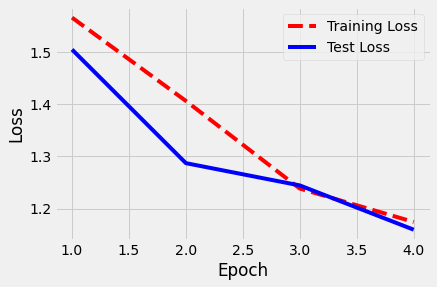

In [48]:
plt.style.use('fivethirtyeight')

# Get training and test loss histories
training_loss = train_history.history['loss']
test_loss = train_history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [49]:
pred = model.predict(test_dataset, verbose=1)

473/473 [==============================] - 60s 127ms/step


In [50]:
# save for ensemble
np.save('xlm-roberta', pred)

In [51]:
pred_sentiment = np.argmax(pred, axis=1)

print(pred_sentiment)

[2 2 3 ... 3 3 3]


In [52]:
submission = pd.DataFrame({'review_id': test_dup['review_id'],
                           'rating': pred_sentiment})

# Submit Predictions
Lastly, convert our rating values back to 1 - 5

In [53]:
submission['rating'] = submission['rating'].map(rating_mapper_decode)

submission.to_csv('submission', index=False)